In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax
from time import time
from pymatching import Matching

from core.quantum_error_correction_code import SurfaceCode, deformation_cmap, relevancy_tensor
from core.neural_network import CNNDual, save_params
from core.perfect_maximum_likelihood_decoder import PMLD

In [3]:
BATCH_SIZE = 32
GENERAL_TRAINING_BATCHES = 10_000_000
FINETUNING_TRAINING_BATCHES = 0 #250_000

CODE_DISTANCE = 5

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 2_000
TRANSITION_STEP = 200_000
DECAY_RATE = 0.95

# Number of filters, Kernal size, Stride
NUM_FILTERS = CODE_DISTANCE**2-1
# NUM_FILTERS = int(2**jnp.ceil(jnp.log2(CODE_DISTANCE**2-1)))
CONV_LAYERS_INPUT_1 = [(NUM_FILTERS,2,1,0)]
CONV_LAYERS_INPUT_2 = [(NUM_FILTERS,1,1,0)]
CONV_LAYERS_STAGE_2 = [(NUM_FILTERS,2,1,0)]
FC_LAYERS = [50, 2]
print(f"{NUM_FILTERS = }")

SEED = 16

# NOTE: Train on a specific deformation or set to None to train on all deformations and find the best one
# Find the best deformation
# DEFORMATION = "Best"
# Create a generalized decoder
# DEFORMATION = "Generalized"
# No deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
# The XZZX deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[::2].set(3)
# The XY deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[:].set(2)
# The C1 deformation (extended)
DEFORMATION = jnp.zeros((CODE_DISTANCE, CODE_DISTANCE), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2)

p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
ERROR_PROB_TRAINING_SCALE = 2.0

settings = {
    "CODE_DISTANCE": CODE_DISTANCE,
    "ERROR_PROBS": ERROR_PROBS,
    "CONV_LAYERS_INPUT_1": CONV_LAYERS_INPUT_1,
    "CONV_LAYERS_INPUT_2": CONV_LAYERS_INPUT_2,
    "CONV_LAYERS_STAGE_2": CONV_LAYERS_STAGE_2,
    "FC_LAYERS": FC_LAYERS,
}

NUM_FILTERS = 24


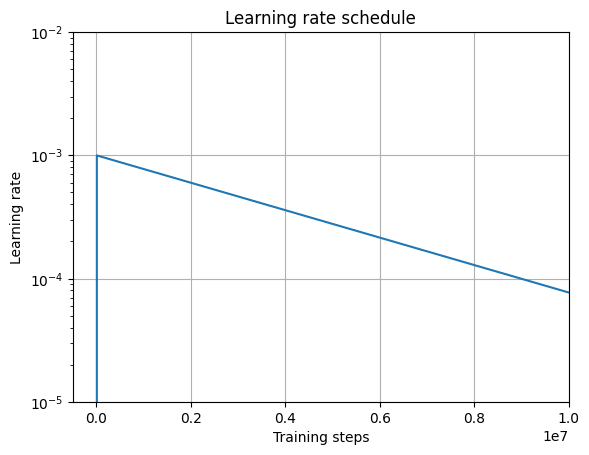

In [4]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, GENERAL_TRAINING_BATCHES+FINETUNING_TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.yscale('log')
plt.title("Learning rate schedule")
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim(xmax=GENERAL_TRAINING_BATCHES+FINETUNING_TRAINING_BATCHES)
plt.ylim(1E-5, 1E-2)
plt.show()

optimizer = optax.adam(learning_rate)

In [5]:
def sample_deformation(
    key, 
    probs: jnp.ndarray
):
    """
    Samples a specific deformation based on a probability distribution on each data qubit.

    probs: Matrix of shape (6,*shape) with axis 0 summing to 1 in all cases

    return: Deformation array of size prod(*shape)
    """
    return _sample_deformation(key, probs)

@jit
def _sample_deformation(
    key, 
    probs: jnp.ndarray
):
    # Cumulative probability
    cp = jnp.cumsum(probs.reshape(6, -1), axis=0)
    # Random variable for sampling
    rv = random.uniform(key, shape=cp.shape[1])
    # Find the first index where the cumulative probability is greater than the random variable
    return (cp > rv).argmax(axis=0)

In [6]:
def train(
    random_seed: int,
    code: SurfaceCode,
    probabilities: jnp.ndarray,
    optimizer: optax.GradientTransformation,
    model: CNNDual
):
    @jit
    def loss_fn(
        model_params,
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Loss function for the model. The loss is the binary cross entropy (BCE) between the
        model output and the logicals. The BCE is weighted by the probability of the deformation.
        """
        # Calculate the BCE
        idv_loss = optax.sigmoid_binary_cross_entropy(
            logits=model.apply_batch(model_params, x1, x2),
            labels=y
        ).mean(axis=1)
        # If DEFORMATION is set, we don't use weights
        # and just return the mean BCE
        if isinstance(DEFORMATION, jnp.ndarray) or DEFORMATION == "Generalized":
            return jnp.mean(idv_loss)
        # Calculate the weights for the BCE
        probs = nn.softmax(model_params["deformation_dist"], axis=0).reshape(6, -1).T[None, :, :]
        err_idx = (errors[:,0,:] + 2*errors[:,1,:])
        # The inner sum is over the deformation probabilities on the same data qubit
        # The outer sum is over the data qubits for the same batch
        weights = jnp.prod(jnp.sum(probs*relevancy_tensor[err_idx, deformations], axis=2), axis=1)
        # Weights are applied to the BCE
        # 1 is added to all weights in case they all sum to less than 0.01 as to avoid devision by 0
        return jnp.average(idv_loss, weights=weights + (weights.sum() < .01).astype(jnp.float32))

    @jit
    def update(
        model_params, 
        deformations: jnp.ndarray,
        errors: jnp.ndarray,
        x1: jnp.ndarray,
        x2: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, deformations, errors, x1, x2, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
        deformations: jnp.ndarray,
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        parity_infos = vmap(
            code.deformation_parity_info
        )(deformations)
        errors = vmap(
            code.error,
            in_axes=(0, None),
        )(data_key[:-1], probabilities)
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, 0),
        )(errors, parity_infos)
        return imgs[:,None,:,:], logicals, errors, data_key[-1]

    @jit
    def sampled_deformations(
        deformation_key,
        probs: jnp.ndarray,
    ):
        deformation_keys = random.split(deformation_key, num=BATCH_SIZE+1)
        deformations = vmap(
            sample_deformation, 
            in_axes=(0, None)
        )(deformation_keys[1:], probs)
        return deformations, deformation_keys[0]
    
    @jit
    def likeliest_deformations(
        deformation_key,
        probs: jnp.ndarray,
    ):
        # Same deformation for all batches
        deformation = probs.argmax(axis=0).flatten()
        deformations = jnp.tile(deformation, reps=(BATCH_SIZE, 1))
        return deformations, deformation_key

    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        ) = val

        # deformations shape=(BATCH_SIZE, NUM_DATA_QUBITS)
        if isinstance(DEFORMATION, jnp.ndarray):
            # If DEFORMATION is set, we only train on that deformation
            deformations = jnp.tile(DEFORMATION, reps=(BATCH_SIZE, 1))
        elif DEFORMATION == "Best":
            # Sample a deformation for each batch
            probs = nn.softmax(model_params["deformation_dist"], axis=0)
            (deformations, deformation_key) = lax.cond(
                i > GENERAL_TRAINING_BATCHES,
                lambda args: likeliest_deformations(*args),
                lambda args: sampled_deformations(*args),
                operand=(deformation_key, probs)
            )
        elif DEFORMATION == "Generalized":
            # Sample a deformation for each batch with uniform distribution
            probs = jnp.ones_like(model_params["deformation_dist"]) / 6
            (deformations, deformation_key) = sampled_deformations(deformation_key, probs)
        # deformation_images shape=(BATCH_SIZE, 6, CODE_DISTANCE, CODE_DISTANCE)
        deformation_images = vmap(code.deformation_image)(deformations)

        # syndrome_images shape=(BATCH_SIZE, 1, CODE_DISTANCE+1, CODE_DISTANCE+1)
        # logicals shape=(BATCH_SIZE, 2)
        syndrome_images, logicals, errors, data_key = get_data(
            data_key,
            deformations,
        )
        loss, model_params, opt_state = update(
            model_params,
            deformations,
            errors,
            syndrome_images,
            deformation_images,
            logicals,
            opt_state,
        )
        losses = losses.at[i].set(loss)
        # Recentering the deformation distribution to avoid numerical issues (the softmax function is invariant to additive constants)
        model_params["deformation_dist"] = model_params["deformation_dist"] - model_params["deformation_dist"].mean(axis=0)

        return (
            model_params,
            opt_state,
            data_key,
            deformation_key,
            losses,
        )
    
    init_key, data_key, deformation_key = random.split(
        key = random.key(random_seed),
        num=3
    )
    num_itr = GENERAL_TRAINING_BATCHES + FINETUNING_TRAINING_BATCHES

    model_params = model.init(init_key)
    # The deformation distribution is initialized to be uniform over all deformations
    if isinstance(DEFORMATION, jnp.ndarray):
        # If DEFORMATION is set, we only train on that deformation
        model_params["deformation_dist"] = 1000*(code.deformation_image(DEFORMATION) - .5)
    else:
        # If DEFORMATION is not set, we train on all deformations
        # and the deformation distribution is initialized to be uniform over all deformations
        model_params["deformation_dist"] = jnp.zeros(
            shape=(6, CODE_DISTANCE, CODE_DISTANCE),
            dtype=jnp.float32
        )
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=num_itr, dtype=jnp.float32)

    val_init = (
        model_params,
        optimizer_state,
        data_key,
        deformation_key,
        losses,
    )

    vals = lax.fori_loop(0, num_itr, _fori_body, val_init)

    return vals

In [7]:
code = SurfaceCode(L=CODE_DISTANCE)
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
for name, layer_sizes in model.layer_sizes.items():
    print(name, layer_sizes)

t0 = time()

(
    model_params,
    opt_state,
    data_key,
    deformation_key,
    losses,
) = train(
    random_seed=SEED,
    code=code,
    probabilities=ERROR_PROBS*ERROR_PROB_TRAINING_SCALE,
    optimizer=optimizer,
    model=model
)

if DEFORMATION is "Generalized":
    save_params(model_params, settings, f"data/CNN_G_L{CODE_DISTANCE}.json")
elif DEFORMATION is "Best":
    save_params(model_params, settings, f"data/CNN_B_L{CODE_DISTANCE}.json")
elif isinstance(DEFORMATION, jnp.ndarray):
    save_params(model_params, settings, f"data/CNN_S_L{CODE_DISTANCE}_{''.join(str(d) for d in DEFORMATION)}.json")

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

CNN_input_1 [(1, 6, 6), (24, 5, 5)]
CNN_input_2 [(6, 5, 5), (24, 5, 5)]
CNN_stage_2 [(24, 5, 5), (24, 4, 4)]
MLP_stage_3 [384, 50, 2]


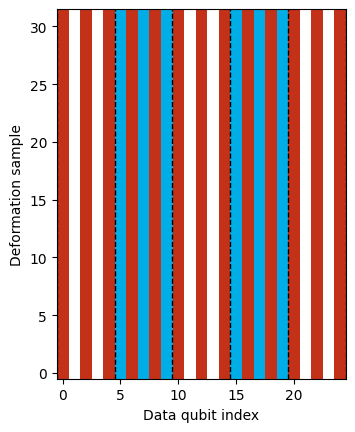

In [8]:
probs = nn.softmax(model_params["deformation_dist"], axis=0)
keys = random.split(random.key(61), num=BATCH_SIZE)
deformations = vmap(sample_deformation, in_axes=(0, None))(keys, probs)

plt.figure()
# plt.imshow(deformations, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.imshow(jnp.array([0,0,2,3,3,2])[deformations], interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
plt.vlines(
    jnp.arange(0, CODE_DISTANCE+1)*CODE_DISTANCE-.5,
    ymin=-.5, ymax=BATCH_SIZE+.5,
    color="black", linewidth=1, linestyle="--"
)
plt.ylim(-.5, BATCH_SIZE-.5)
plt.xlabel("Data qubit index")
plt.ylabel("Deformation sample")
plt.show()

/tmp/ipykernel_43734/2555412948.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()])


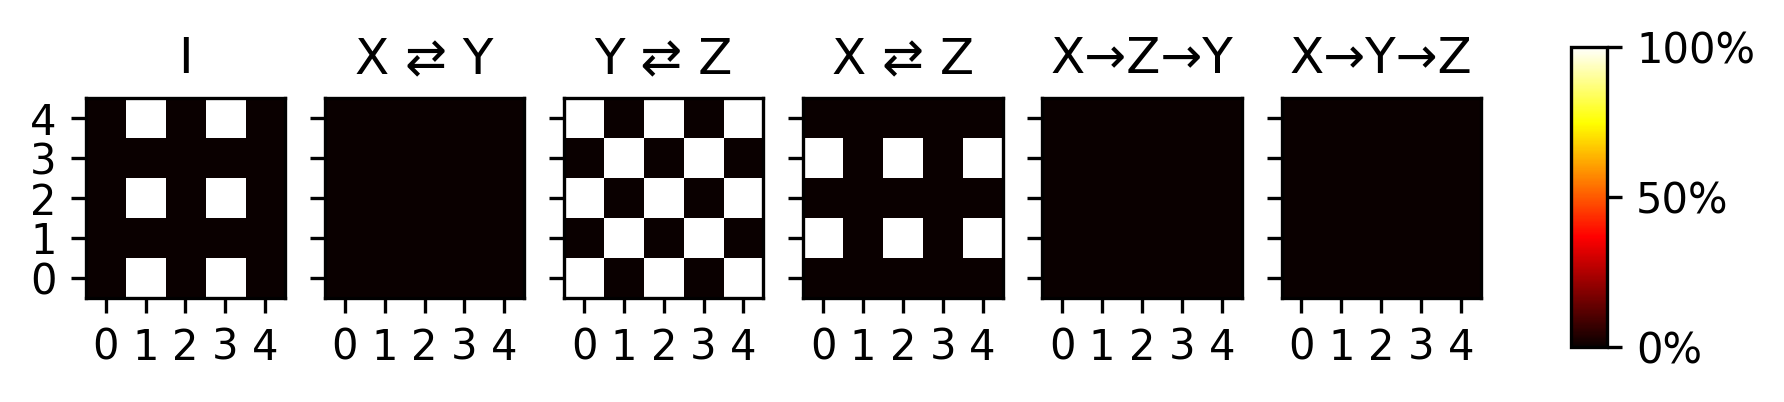

In [9]:
fig, axs = plt.subplots(ncols=6, figsize=(6,1), sharey=True, dpi=300)
probs = nn.softmax(model_params["deformation_dist"], axis=0)
for i in range(6):
    im = axs[i].imshow(
        probs[i], 
        origin='lower',
        cmap='hot',
        vmin=probs.min(),
        vmax=probs.max(),
    )
    axs[i].set_title([
        "I",
        "X ⇄ Y",
        "Y ⇄ Z",
        "X ⇄ Z",
        "X→Z→Y",
        "X→Y→Z",
    ][i], rotation=0)
    axs[i].set_xticks(jnp.arange(CODE_DISTANCE))
    axs[i].set_yticks(jnp.arange(CODE_DISTANCE))
cax = fig.add_axes((.95,0,.02,1))
cb = plt.colorbar(im, cax=cax)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()])
plt.show()

2025-04-02 12:06:34.346426: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 1.47GiB (1580119040 bytes) by rematerialization; only reduced to 3.72GiB (4000000000 bytes), down from 3.72GiB (4000000000 bytes) originally
2025-04-02 12:06:34.372525: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 1.47GiB (1580119040 bytes) by rematerialization; only reduced to 3.72GiB (4000000000 bytes), down from 3.72GiB (4000000000 bytes) originally
2025-04-02 12:06:34.399959: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 1.47GiB (1580119036 bytes) by rematerialization; only reduced to 3.72GiB (4000000004 bytes), down from 3.72GiB (4000000004 bytes) originally
2025-04-02 12:06:34.427992: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 1.47GiB (1580119040 bytes) by remater

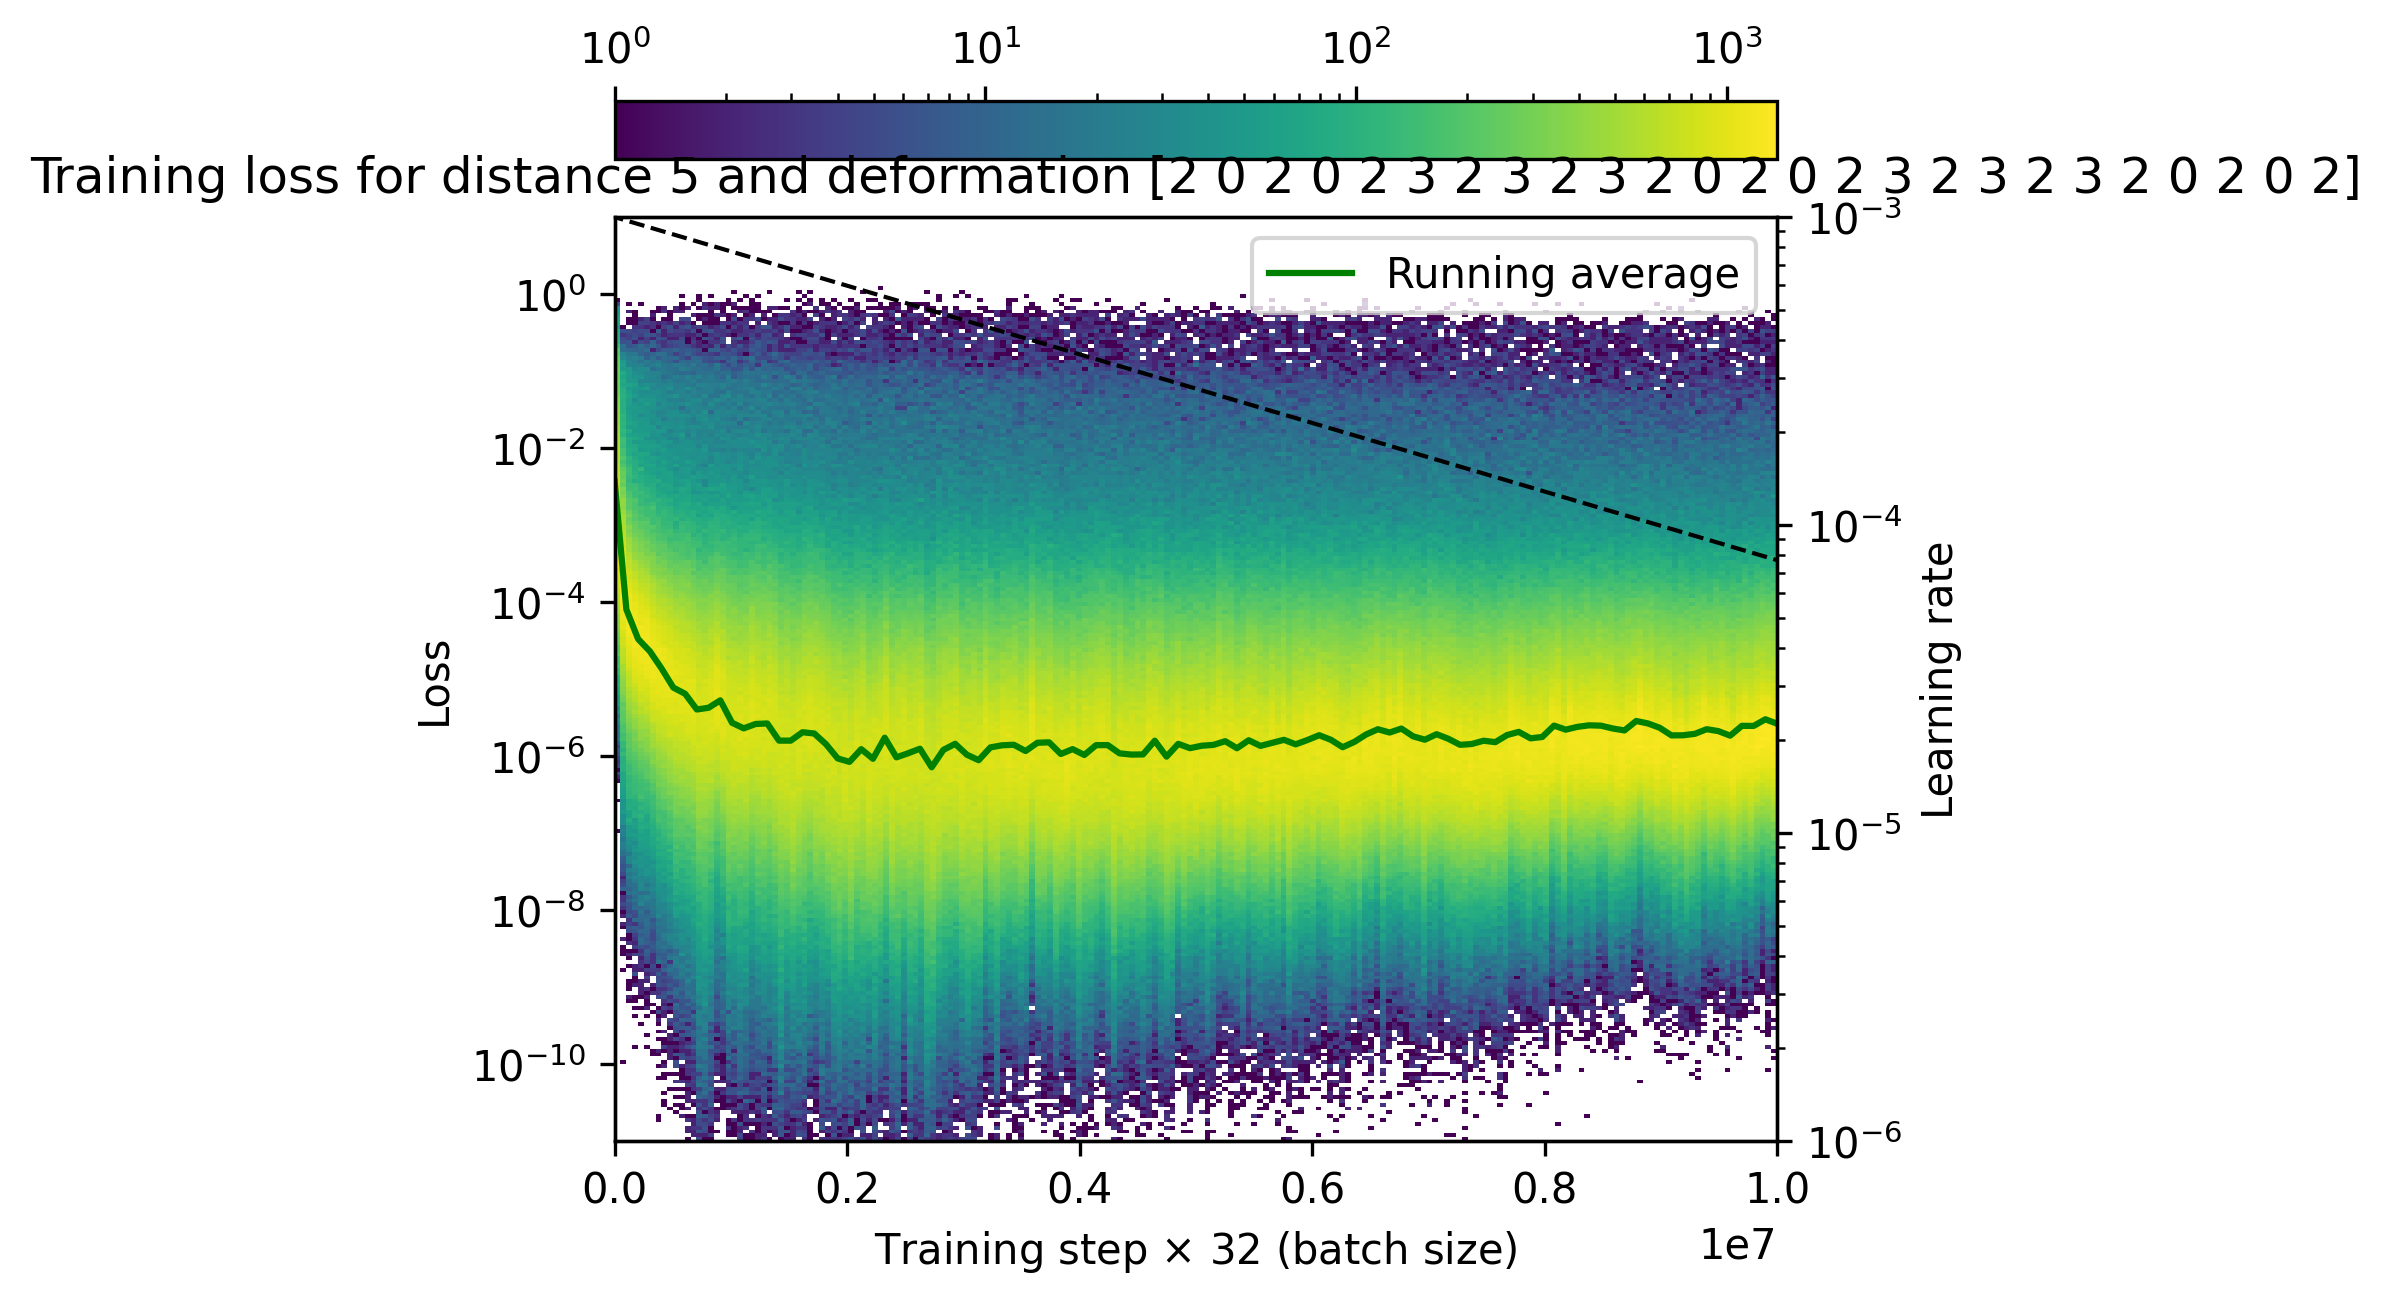

In [10]:
sigma = 25_000

x = jnp.linspace(0, losses.shape[0]-1, 100)[:, None]
idx = jnp.arange(losses.shape[0])[None, :]
dist = jnp.exp(-(idx - x)**2 / sigma**2)
dist = dist / dist.sum(axis=1)[:, None]
running_avg = jnp.exp((dist * jnp.log(losses[None, :])).sum(axis=1))
# running_avg = (dist * losses[None, :]).sum(axis=1)

y_max = jnp.ceil(jnp.log10(losses).max()).astype(jnp.int32)
y_min = jnp.floor(jnp.log10(jnp.percentile(losses, .05))).astype(jnp.int32)
step = jnp.arange(losses.shape[0])
plt.figure(dpi=300, figsize=(5,5))
plt.hist2d(
    x=step, 
    y=losses, 
    bins=[
        jnp.linspace(0, losses.shape[0], 200),
        jnp.logspace(y_min, y_max, (y_max-y_min)*20+1)
    ],
    norm=LogNorm(vmin=1),
)
# plt.plot(step, losses, ',', alpha=.5)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel(f"Training step $\\times$ {BATCH_SIZE} (batch size)")
plt.colorbar(location="top")
plt.plot(x[:,0], running_avg, '-g', label="Running average")
plt.legend(loc=1)

plt.twinx()
plt.plot(step, learning_rate(step), '--k', lw=1)
plt.yscale('log')
plt.ylabel("Learning rate")
plt.ylim(1E-6, 1E-3)

plt.xlim(0, losses.shape[0])

if DEFORMATION is not None:
    plt.title(f"Training loss for distance {CODE_DISTANCE} and deformation {DEFORMATION}")
    plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.eps", bbox_inches='tight')
    plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.png", bbox_inches='tight')
else:
    plt.title(f"Training loss for distance {CODE_DISTANCE}")
    plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}.eps", bbox_inches='tight')
    plt.savefig(f"figs/cnn_decoder_and_deformation_on_distance{CODE_DISTANCE}.png", bbox_inches='tight')

plt.show()

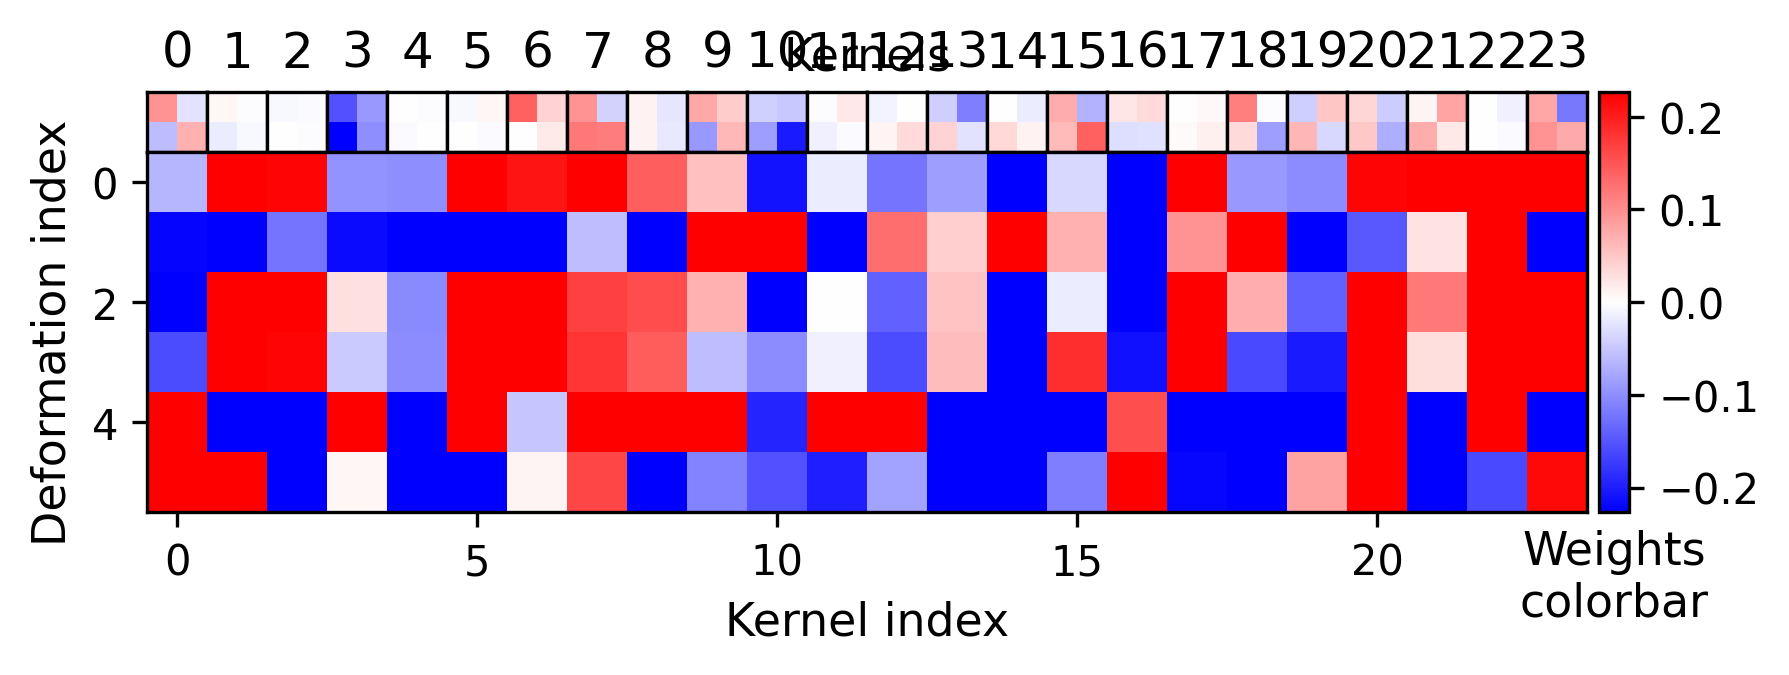

In [11]:
kernels = model_params['CNN_input_1'][0]['w']
mask = model_params['CNN_input_2'][0]['w'][:,:,0,0]
lims = jnp.abs(kernels).max()

fig_width = 5
fig = plt.figure(dpi=300, figsize=(
    fig_width / (kernels.shape[0]+1),
    fig_width / (kernels.shape[0]+1)
))
kernel_axs = [
    fig.add_axes((i,0,1,1))
    for i in range(kernels.shape[0])
]
mask_ax = fig.add_axes((0,-mask.shape[1],mask.shape[0],mask.shape[1]))
cax = fig.add_axes((mask.shape[0]+.2,-mask.shape[1],.5,mask.shape[1]+1))

for i, ax in enumerate(kernel_axs):
    im = ax.imshow(kernels[i,0].astype(jnp.float32), vmin=-lims, vmax=lims, cmap="bwr")
    ax.set_title(f"{i}")
    ax.set_xticks([])
    ax.set_yticks([])
im = mask_ax.imshow(mask.T.astype(jnp.float32), vmin=-lims, vmax=lims, cmap="bwr")
mask_ax.set_xlabel("Kernel index", fontsize=11)
mask_ax.set_ylabel("Deformation index", fontsize=11)
mask_ax.set_title("Kernels", y=1.16, fontsize=11)
fig.colorbar(im, cax=cax)
cax.set_xlabel("Weights\ncolorbar", fontsize=11)

# plt.savefig(f"figs/cnn_decoder_and_deformation_weights_map_on_distance{CODE_DISTANCE}.eps", bbox_inches='tight')
# plt.savefig(f"figs/cnn_decoder_and_deformation_weights_map_on_distance{CODE_DISTANCE}.png", bbox_inches='tight')
plt.show()

# Compare to other decoders

In [12]:
data_key = random.key(42)
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

In [13]:
def get_data(
    data_key,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    print(errors.shape)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [21]:
data_key = random.key(42)

In [22]:
subkey, data_key = random.split(data_key)
probs = nn.softmax(model_params["deformation_dist"], axis=0)
# deformation = sample_deformation(subkey, probs)
deformation = probs.argmax(axis=0).flatten()

# No deformation
deformation = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
# The XZZX deformation
# deformation = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[::2].set(3)
# The XY deformation
# deformation = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[:].set(2)
# The C1 deformation (extended)
# deformation = jnp.zeros((CODE_DISTANCE, CODE_DISTANCE), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2)

parity_info = code.deformation_parity_info(deformation)
deformation_img = code.deformation_image(deformation)[None,:,:,:]
print(deformation.reshape(CODE_DISTANCE, CODE_DISTANCE))

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [23]:
imgs, syndromes, logicals, data_key = get_data(
    data_key, 
    batch_size=1_000_000, 
    parity_info=parity_info
)

(1000000, 2, 25)


NN-model decoder

In [24]:
nn_logicals = jnp.empty((imgs.shape[0], 2), dtype=jnp.int32)

chunck_size = 100_000
for i in range(imgs.shape[0] // chunck_size):
    a = i*chunck_size
    b = a+chunck_size
    nn_logicals = nn_logicals.at[a:b].set((nn.sigmoid(
        model.apply_batch(model_params, imgs[a:b], deformation_img)
    ) > .5).astype(jnp.int32))

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * nn_logicals[:, 0] + nn_logicals[:, 1]
nn_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

MWPM decoder

In [25]:
def deform_recovery_batch(
    recovery = jnp.ndarray,
):
    def _deform_recovery(
        recovery: jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[0, 1], [1, 1]],  # X-Y-Z
            [[1, 1], [1, 0]],  # X-Z-Y
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[deformation]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

# Decodes the un-deformed surface code and then deforms the recovery operation
matcher = Matching(
    jnp.append(code.hx_original, code.hz_original, axis=1)
)
recovery = matcher.decode_batch(syndromes)
recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
recovery = deform_recovery_batch(recovery)
mwpm_logicals = logicals_of_recovery(recovery, parity_info)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * mwpm_logicals[:, 0] + mwpm_logicals[:, 1]
mwpm_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

Perfect maximum likelihood decoder

In [26]:
# The PML decoder can't handle codes with a lot of qubits
if CODE_DISTANCE == 3:
    perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
    pml_logicals = perfect_decoder.decode_batch(syndromes)

    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * pml_logicals[:, 0] + pml_logicals[:, 1]
    pml_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)
else:
    pml_hist = jnp.zeros((4,4))

### Compare

2.0
0.14048499


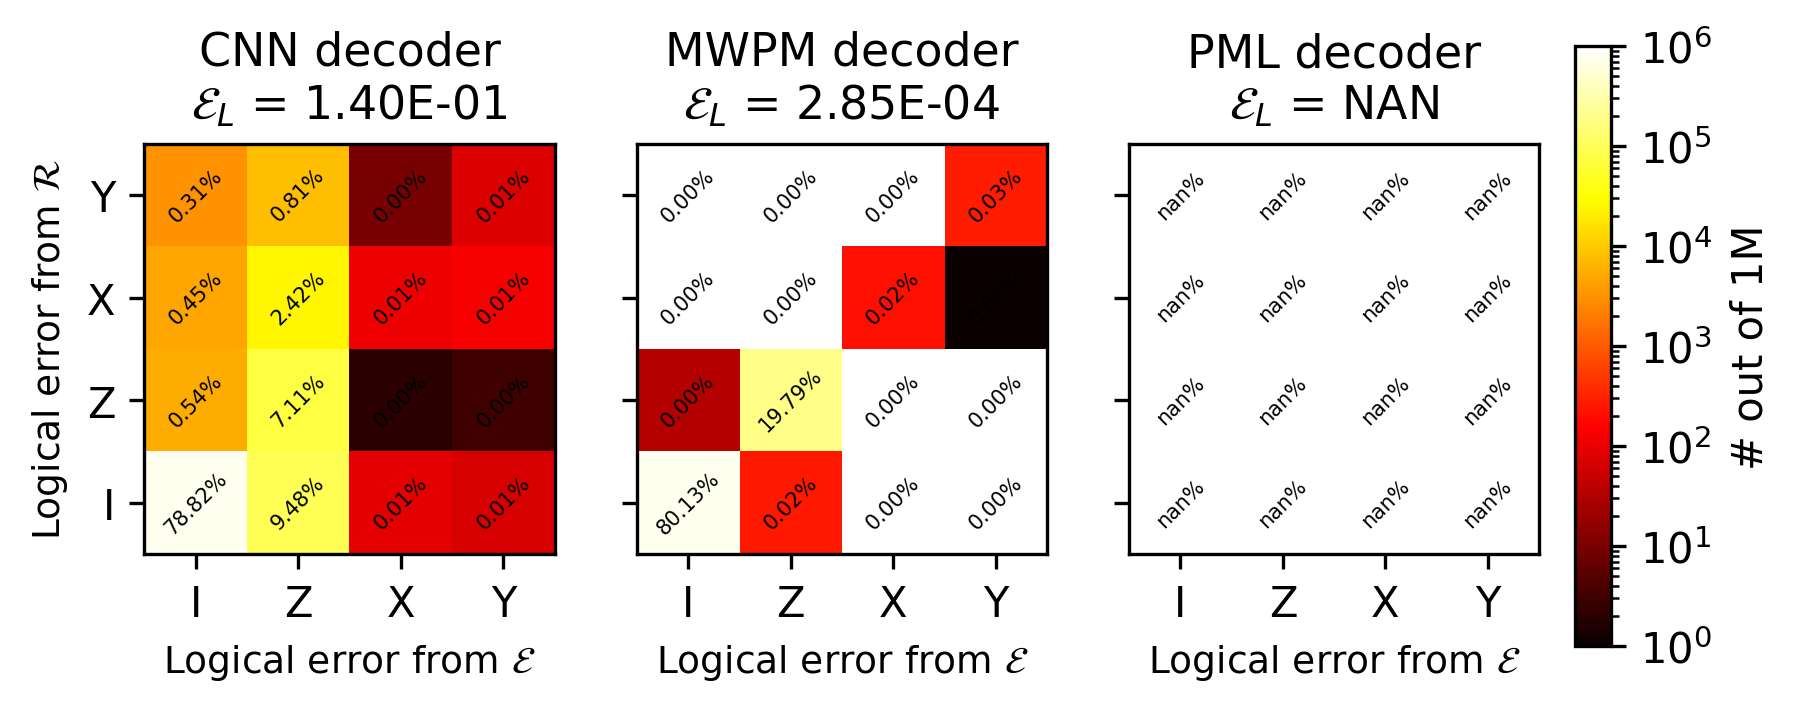

[2 0 2 0 2 3 2 3 2 3 2 0 2 0 2 3 2 3 2 3 2 0 2 0 2]


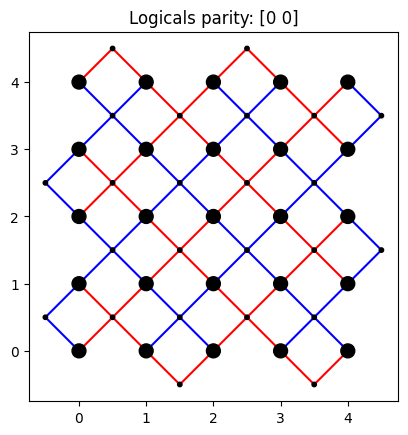

% Draw the plaquettes
\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\filldraw[fill=black!10, draw=none] (0,4) -- (2,4) -- (2,6) -- (0,6) -- cycle;
\filldraw[fill=black!5, draw=none] (0,6) -- (2,6) -- (2,8) -- (0,8) -- cycle;
\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;
\filldraw[fill=black!5, draw=none] (2,4) -- (4,4) -- (4,6) -- (2,6) -- cycle;
\filldraw[fill=black!10, draw=none] (2,6) -- (4,6) -- (4,8) -- (2,8) -- cycle;
\filldraw[fill=black!10, draw=none] (4,0) -- (6,0) -- (6,2) -- (4,2) -- cycle;
\filldraw[fill=black!5, draw=none] (4,2) -- (6,2) -- (6,4) -- (4,4) -- cycle;
\filldraw[fill=black!10, draw=none] (4,4) -- (6,4) -- (6,6) -- (4,6) -- cycle;
\filldraw[fill=black!5, draw=none] (4,6) -- (6,6) -- (6,8) -- (4,8) -- cycle;
\filldraw[fill=black!5, draw=none] (

In [27]:
# labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']
labels = ['I', 'Z', 'X', 'Y']

plot: tuple[plt.Figure, list[plt.Axes]] = plt.subplots(ncols=3, sharey=True)
fig, axs = plot
fig.set_figwidth(6)
fig.set_figheight(2)
fig.set_dpi(300)
axs[0].set_ylabel(f'Logical error from $\\mathcal{{R}}$', fontsize=9)
for ax, hist, name in zip(
    axs,
    [nn_hist, mwpm_hist, pml_hist],
    ["CNN", "MWPM", "PML"]
):
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='hot',
        # vmin=0,
        # vmax=hist.sum(),
        norm=LogNorm(vmin=1, vmax=1E6)
    )
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel(f'Logical error from $\\mathcal{{E}}$', fontsize=9)
    for x, row in enumerate(jnp.array(hist).T):
        for y, count in enumerate(row):
            ax.text(x, y, f'{count/hist.sum():.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor', fontsize=5)
    ax.set_title(f'{name} decoder\n$\\mathcal{{E}}_L$ = {1 - hist.diagonal().sum() / hist.sum():.2E}', fontsize=11)
cbar = fig.colorbar(img, cax=fig.add_axes((.92,0,.02,1)))
cbar.set_label("# out of 1M")

# plt.savefig(f"figs/decoder_comparison_specific_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.eps", bbox_inches='tight', dpi=300)
# plt.savefig(f"figs/decoder_comparison_specific_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.png", bbox_inches='tight', dpi=300)

print(ERROR_PROB_TRAINING_SCALE)
print(1 - nn_hist.diagonal().sum() / nn_hist.sum())
plt.show()

print(DEFORMATION)
code.show(parity_info)
print(code.show_latex_code(parity_info, deformation))